# How to visualize the trace of a neuron

This tutorial showcases how to pull a segment from S3 via CloudVolume, fit its trace with brainlit's `fit_spline` module, and visualize it. Here, we will pull segments from [s3://open-neurodata/brainlit/brain1_segments](s3://open-neurodata/brainlit/brain1_segments).

Downloading: 100%|██████████| 1/1 [00:00<00:00, 20.42it/s]
Found 77 branches in segment 161
Downloading: 100%|██████████| 1/1 [00:00<00:00, 18.10it/s]
Found 118 branches in segment 111
Downloading: 100%|██████████| 1/1 [00:00<00:00, 11.90it/s]
Found 179 branches in segment 2
Downloading: 100%|██████████| 1/1 [00:00<00:00, 13.04it/s]
Found 459 branches in segment 235
Downloading: 100%|██████████| 1/1 [00:00<00:00, 16.71it/s]
Found 328 branches in segment 35
Downloading: 100%|██████████| 1/1 [00:00<00:00, 19.85it/s]
Found 134 branches in segment 7
Downloading: 100%|██████████| 1/1 [00:00<00:00, 28.68it/s]
Found 138 branches in segment 99


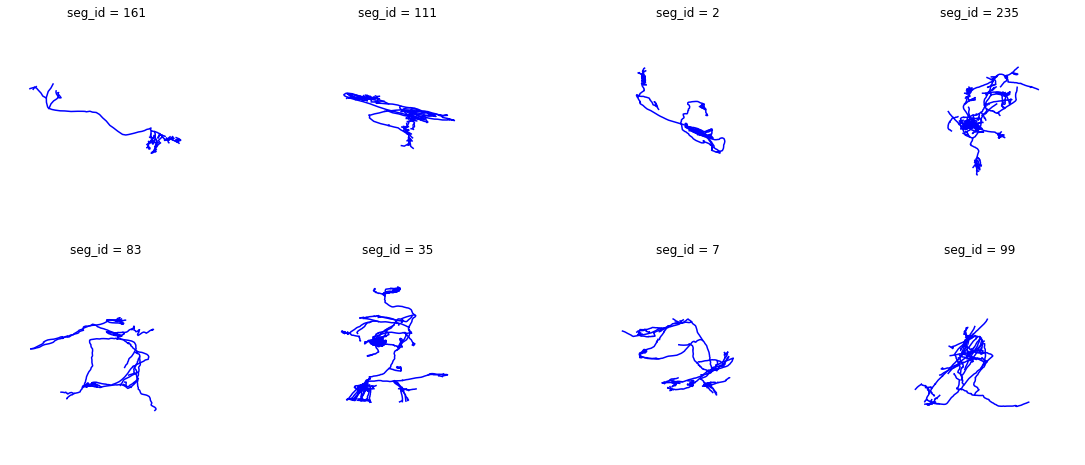

In [10]:
import numpy as np
import brainlit
from brainlit.algorithms.trace_analysis.fit_spline import GeometricGraph
from brainlit.utils.session import read_s3, df_to_graph
from scipy.interpolate import BSpline, splev
import matplotlib.pyplot as plt

def df_to_geometric_graph(df_voxel):
    G = GeometricGraph()

    # add nodes
    for index, row in df_voxel.iterrows():
        id = int(row["sample"])
        
        loc_x = int(row["x"])
        loc_y = int(row["y"])
        loc_z = int(row["z"])
        loc = np.array([loc_x, loc_y, loc_z])
        G.add_node(id, loc=loc)
    
    # add edges
    for index, row in df_voxel.iterrows():
        child = int(row["sample"])
        parent = int(row["parent"])

        if parent > min(df_voxel["parent"]):
            G.add_edge(parent, child)

    return G

fig = plt.figure(figsize=(20, 8))

s3_path = "s3://open-neurodata/brainlit/brain1_segments"
mip = 0
seg_ids = [161, 111, 2, 235, 83, 35, 7, 99]

for i, seg_id in enumerate(seg_ids):
    ax = fig.add_subplot(2, 4, i+1, projection="3d")
    df_neuron = read_s3(s3_path, seg_id, mip)
    g_neuron = df_to_geometric_graph(df_neuron)
    spline_tree = g_neuron.fit_spline_tree_invariant()
    splines_L = len(spline_tree.nodes)
    print("Found {} branches in segment {}".format(splines_L, seg_id))

    for node in spline_tree.nodes:
        branch = spline_tree.nodes[node]
        tck, u = branch["spline"]
        t = tck[0]
        c = tck[1]
        k = tck[2]
        n_dim = len(c)
        L = len(u)
        trace = np.zeros((n_dim, L))
        for j, dim in enumerate(c):
            spl = BSpline(t, dim, k)
            trace[j, :] = spl(u)
        ax.plot(trace[0, :], trace[1, :], trace[2, :], "b-")

    # Hide axes ticks
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.axis('off')

    ax.set_title("seg_id = %d" % seg_id)